**Part 2. AI Agent 활용 프로젝트**

- Chapter 03. N개 이상의 Agent

    - **📒[실습]** Clip 05. Supervisor - 여행 날씨와 장소를 추천하고 저장하는 Agent🗒️

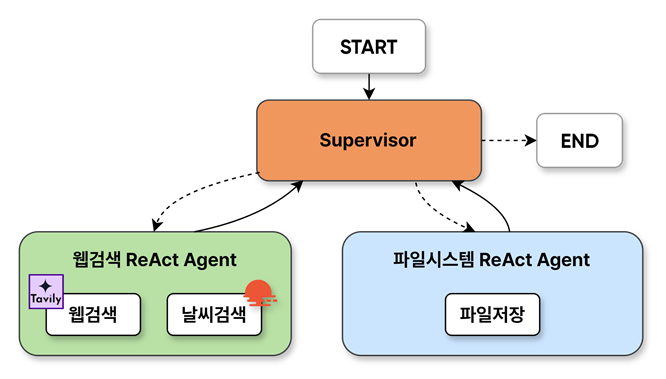

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("OPENWEATHERMAP_API_KEY")

### 웹 검색과 날씨 예보를 기반으로 여행지를 추천하는 Agent

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

In [3]:
from langchain_core.tools import tool
import requests
import json

open_weather_api_key = os.getenv("OPENWEATHERMAP_API_KEY")

@tool
def weather_search(city: str) -> dict:
    """Get the current, daily forecast weather(8days) and overview for a given city.

    Args:
        city (str): The name of the city to get the weather for.
    """

    def get_coordinates(city, api_key):
        url = f"http://api.openweathermap.org/geo/1.0/direct?q={city}&limit=1&appid={api_key}"
        response = requests.get(url)
        data = response.json()

        if not data:
            raise ValueError(f"도시 '{city}'에 대한 정보를 찾을 수 없습니다.")

        lat = data[0]["lat"]
        lon = data[0]["lon"]
        return lat, lon

    lat, lon = get_coordinates(city, open_weather_api_key)

    api = f"""https://api.openweathermap.org/data/3.0/onecall?lat={lat}&lon={lon}&lang=kr&appid={open_weather_api_key}"""

    result = requests.get(api)
    data = json.loads(result.text)
    current_weather = data["current"]
    daily_weather = data["daily"]

    api = f"""https://api.openweathermap.org/data/3.0/onecall/overview?lat={lat}&lon={lon}&appid={open_weather_api_key}"""
    result = requests.get(api)
    data = json.loads(result.text)

    weather_overview = data["weather_overview"]

    return {
        "current_weather": current_weather,
        "daily_weather": daily_weather,
        "weather_overview": weather_overview,
    }


In [4]:
weather_search("제주도")

C:\Users\pnylo\AppData\Local\Temp\ipykernel_1132\3490513922.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  weather_search("제주도")


{'current_weather': {'dt': 1748240889,
  'sunrise': 1748204860,
  'sunset': 1748255659,
  'temp': 284.41,
  'feels_like': 283.16,
  'pressure': 1018,
  'humidity': 60,
  'dew_point': 276.94,
  'uvi': 5.71,
  'clouds': 0,
  'visibility': 10000,
  'wind_speed': 4.12,
  'wind_deg': 280,
  'weather': [{'id': 800,
    'main': 'Clear',
    'description': '맑음',
    'icon': '01d'}]},
 'daily_weather': [{'dt': 1748228400,
   'sunrise': 1748204860,
   'sunset': 1748255659,
   'moonrise': 1748200380,
   'moonset': 1748252940,
   'moon_phase': 0.96,
   'summary': 'Expect a day of partly cloudy with clear spells',
   'temp': {'day': 286.14,
    'min': 283.23,
    'max': 286.95,
    'night': 284.77,
    'eve': 285.96,
    'morn': 283.4},
   'feels_like': {'day': 284.77,
    'night': 283.37,
    'eve': 284.63,
    'morn': 281.86},
   'pressure': 1019,
   'humidity': 49,
   'dew_point': 275.69,
   'wind_speed': 2.2,
   'wind_deg': 288,
   'wind_gust': 3.39,
   'weather': [{'id': 803,
     'main': 'Clo

In [5]:
from langchain_openai import ChatOpenAI


llm = ChatOpenAI(model="gpt-4o")

In [6]:
from langgraph.prebuilt import create_react_agent

search_agent = create_react_agent(
    llm,
    tools=[tavily_tool, weather_search],
    prompt="You are a skilled information-seeking agent equipped with web search (tavily_tool) and weather lookup (weather_search) tools to provide accurate and up-to-date information.",
)

### 파일로 정리하는 Agent

In [7]:
from langchain_core.tools import tool

@tool
def save_file(content: str, output_path="file_info.md") -> str:
    """Writes the provided content to a text file at the specified output_path."""
    with open(output_path, "w", encoding="utf-8") as f:
        f.write(content)

    return output_path

In [8]:
file_agent = create_react_agent(
    llm,
    [save_file],
    prompt="You are a file management agent for saving files upon request.",
)

### Supervisor Agent

In [ ]:
from langgraph.graph import MessagesState
from typing import Literal, TypedDict

members = ["file_agent", "search_agent"]
options = members + ["FINISH"]


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


class State(MessagesState): # messages 
    next: str

In [10]:
from langgraph.types import Command
from langgraph.graph import END


system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"] 
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

### 각 에이전트별 노드 설정하기

- search node

- file node

In [11]:
from langchain_core.messages import HumanMessage

def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="search_agent"
                )
            ]
        },
        goto="supervisor",
    )

In [12]:
def file_node(state: State) -> Command[Literal["supervisor"]]:
    result = file_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="file_agent"
                )
            ]
        },
        goto="supervisor",
    )

### Graph Compile!

In [ ]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)
graph_builder.add_edge(START, "supervisor")
graph_builder.add_node("supervisor", supervisor_node)
graph_builder.add_node("file_agent", file_node)
graph_builder.add_node("search_agent", search_node)

In [14]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

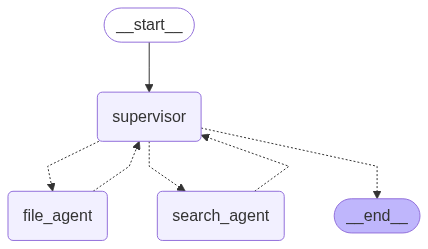

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

테스트 !

In [15]:
config = {"configurable": {"thread_id": "1"}}
while True:
    try:
        user_input = input("질문을 입력하세요: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("안녕히 가세요!")
            break

        print("=====RESPONSE=====")
        async for namespace, chunk in graph.astream(
            {"messages": user_input},
            stream_mode="updates",
            subgraphs=True,
            config=config,
        ):
            for node_name, node_chunk in chunk.items():
                if "messages" in node_chunk:
                    node_chunk["messages"][-1].pretty_print()
                else:
                    print(node_chunk)

    except Exception as e:
        print(f"종료합니다.{e}")
        break

=====RESPONSE=====
{'next': 'search_agent'}
================================== Ai Message ==================================
Tool Calls:
  weather_search (call_zjCcjPaRWNAOQCEbmKMkNLdO)
 Call ID: call_zjCcjPaRWNAOQCEbmKMkNLdO
  Args:
    city: 강릉
================================= Tool Message =================================
Name: weather_search

Error: ValueError("도시 '강릉'에 대한 정보를 찾을 수 없습니다.")
 Please fix your mistakes.
================================== Ai Message ==================================
Tool Calls:
  weather_search (call_appDFp7JShodzEeC6Kzivc3K)
 Call ID: call_appDFp7JShodzEeC6Kzivc3K
  Args:
    city: Gangneung
================================= Tool Message =================================
Name: weather_search

{"current_weather": {"dt": 1748241898, "sunrise": 1748203645, "sunset": 1748255756, "temp": 295.71, "feels_like": 295.56, "pressure": 1016, "humidity": 59, "dew_point": 287.3, "uvi": 1.57, "clouds": 100, "visibility": 10000, "wind_speed": 2.42, "wind_deg": 126, 